## Imports

In [10]:
import numpy as np
from numpy import sin, cos, linalg
from numpy.linalg import norm, svd
import scipy
from scipy.integrate import solve_ivp, simpson
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
from scipy.interpolate import interp1d
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 13,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8200\1244343727.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


# Parameters

In [11]:
M = np.array([[10,0],
              [0,0.5]])
x_initial = np.array([0,0, np.pi/2 ])
x_desired = np.array([15,15, -np.pi/2])
distance_factor = 250
orthogonality_factor = 10
machine_factor = 5
human_factor = 10
steps = 60
T = 10 # Don't change this
t_space = np.linspace(0,T,steps)
epsilon = 2
interp_kind = 'linear'

# Helpful functions

In [12]:
def callback(xk,op=None):
    if callback.iter%100 ==0:
        print("Iteration:", callback.iter)
    callback.iter += 1
callback.iter = 1 

def split_a_and_g(variable):
    m = (variable.size-4)//2
    g = variable[-4:].reshape((2,2)) 
    a_0, a_1 = variable[:m], variable[m:2*m]
    return a_0, a_1, g #a_0 is the head movement, a_1 is the forward or body movement

# Restrictions

In [13]:
def orthogonality_test(variable):
    g = variable[-4:].reshape((2,2))
    sol = solve_ivp(lambda t, x: ode_function(t, x, variable), (0.0, T), 
                    x_initial, t_eval = t_space, method='RK23')
    
    x_final = sol.y[:,-1]
    u, _ , vh = svd(g, full_matrices=False)
    # dist =np.linalg.norm(g.T @ g - np.eye(2), 'fro')
    dist = norm(u @ vh - g, 'fro')
    return dist + np.sqrt(np.sum((x_desired-x_final)**2))

def ode_function(t,vars,variable):

    a_0, a_1, g = split_a_and_g(variable)
    a_0 = interp1d(t_space,a_0, kind=interp_kind, fill_value ='extrapolate')
    a_1 = interp1d(t_space,a_1, kind=interp_kind, fill_value ='extrapolate')
    control = g @ np.array([a_0(t),a_1(t)])
    x, y, theta = vars[0], vars[1], vars[2]
    xdt = control[0]*cos(theta)
    ydt = control[0]*sin(theta)
    thetadt = control[1]

    return np.array([xdt, ydt, thetadt])

# Functional to minimize

In [14]:
def L(variable):
    a_0, a_1, g = split_a_and_g(variable)
    a = np.vstack((a_0,a_1))
    # integrand_human_effort = np.diagonal(a.T @ M @ a)
    sol = solve_ivp(lambda t, vars: ode_function(t, vars, variable), 
                    (0, T), x_initial, 
                    t_eval = t_space, method='RK23')
    x_final = sol.y[:,-1]
    
    u, _ , vh = svd(g, full_matrices=False)
    integrand = np.diagonal(a.T @ M @ a)
    
    human_effort = simpson(integrand, t_space)
    machine_effort = np.sum(np.sqrt(np.diff(sol.y[0])**2 + np.diff(sol.y[1])**2))
    point_achievement = np.sum((x_desired-x_final)**2)
    orthogonality = norm(u@vh - g, 'fro')
    cost = human_factor*human_effort + machine_factor*machine_effort + distance_factor*point_achievement + orthogonality_factor*orthogonality

    if callback.iter%5 ==0:
        clear_output(wait=True)
        print(f'Iteration: {callback.iter}')
        print(human_factor*human_effort, machine_factor*machine_effort,
              distance_factor*point_achievement, orthogonality_factor*orthogonality)
        print(f'cost: {cost}')
    return cost


## Minimizer settings

In [15]:
# bounds = Bounds(lb=-np.pi*np.ones(2*steps+4) , ub= np.pi*np.ones(2*steps+4))
box_bounds = LinearConstraint(np.eye(2*steps+4), lb=-np.pi*np.ones(2*steps+4), 
                          ub=np.pi*np.ones(2*steps+4), keep_feasible=True)
nonlinear_bounds = NonlinearConstraint(orthogonality_test,lb=-epsilon , ub=epsilon)
init_mat = np.sqrt(1/2)*np.array([-1,1,1,-1])
x0 = np.hstack((np.random.random(2*steps),
    init_mat))
callback.iter = 1
# result = minimize(L, x0,callback =callback, 
#                   constraints =[box_bounds, nonlinear_bounds],
#                   method='COBYLA', 
#                   options = {'maxiter':6000}, tol = 1e-9)
result = minimize(L, x0,callback =callback, 
                  constraints =[box_bounds],
                  method='SLSQP', 
                  options = {'maxiter':200})

c:\Users\Usuario\anaconda3\envs\Proper\lib\site-packages\scipy\optimize\_constraints.py:368: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


KeyboardInterrupt: 

## Print and saving part

     fun: 1212.3812452334676
   maxcv: 2.0855659110841875
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 3002
  status: 4
 success: False
       x: array([-0.87842481, -0.34821474,  0.37022551,  0.64426912,  0.97068416,
       -0.21188021,  2.03599006,  0.60007903,  0.85964455,  0.45450287,
       -0.01217724,  0.85298231,  1.66899617,  0.75676836,  0.33978331,
        0.14831301,  0.90629487,  0.62916598,  0.99741393,  0.62526488,
        1.00724282,  0.61900567,  0.66464342,  0.75240275,  0.93138205,
        0.27775028,  0.63327634,  0.50911159,  0.98498341, -0.09821692,
        0.59198007,  0.06089831,  0.30179656,  0.78354466,  0.15626914,
        0.02542924, -0.21420057,  0.52777741, -0.64889167, -0.17029653,
        0.79076282, -0.2738118 ,  0.79743842,  0.87649985,  0.69838884,
        0.5996152 ,  0.67400878, -0.12114562,  0.91109348,  0.61541554,
       -0.2112243 , -0.16966528,  1.31147592,  0.13230165,

Text(0.5, 1.0, 'path')

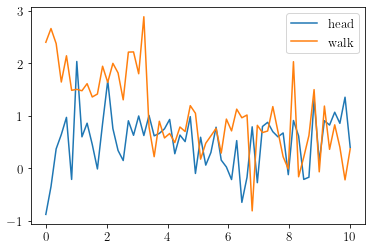

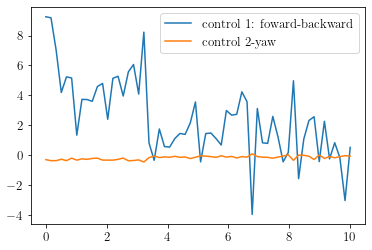

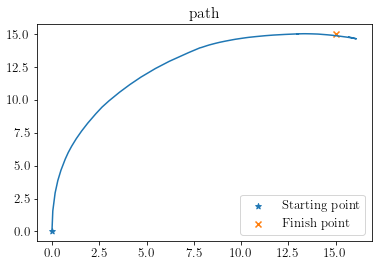

In [ ]:
save = False
print(result)
a_0, a_1, g = split_a_and_g(result.x)
if save:
    with open("results3.pickle", "wb") as f:
        pickle.dump((a_0, a_1, g), f)
        
sol = solve_ivp(lambda t, vars: ode_function(t, vars, result.x), 
                (0, T), x_initial, t_eval=t_space)
plt.figure()
plt.plot(t_space, a_0)
plt.plot(t_space, a_1)
plt.legend(['head', 'walk'])

print(f'Mapping \n {g}')
a = np.vstack((a_0,a_1))
controls = g @ a
plt.figure()
plt.plot(t_space, controls[0])
plt.plot(t_space, controls[1])
plt.legend(['control 1: foward-backward', 'control 2-yaw'])
plt.figure()

plt.scatter(*x_initial[0:2], marker='*')
plt.scatter(*x_desired[0:2], marker='x')
plt.plot(sol.y[0],sol.y[1], '-')
plt.legend(['Starting point', 'Finish point'])
plt.title('path')

# Reading part
Use this if you have a file to read

(44,)
Mapping 
 [[ 0.24121037  2.15111656]
 [ 1.73345202 -0.62708677]]


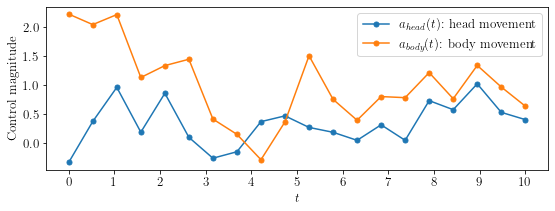

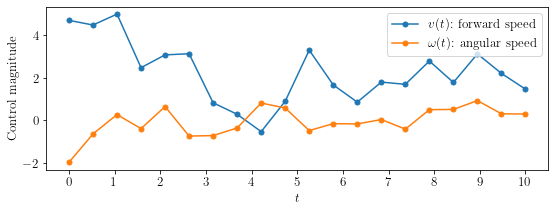

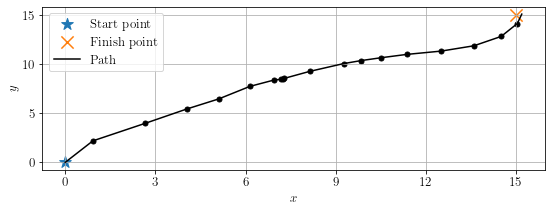

In [ ]:
with open("results2.pickle", "rb") as f:
    a_0,a_1,g=pickle.load(f)

read_res = np.hstack((a_0,a_1,g.flatten()))
print(read_res.shape)
steps = a_0.size
T=10
markersize= 10
figsize=(9,3)
t_space = np.linspace(0,T,steps)
sol = solve_ivp(lambda t, vars: ode_function(t, vars, read_res), 
                (0, T), x_initial, t_eval=t_space)

print(f'Mapping \n {g}')
a = np.vstack((a_0,a_1))

fig1 = plt.figure(figsize=figsize)
plt.plot(t_space, a_0, marker=".", markersize=markersize)
plt.plot(t_space, a_1, marker=".", markersize=markersize)
plt.legend([r'$a_{head}(t)$: head movement', '$a_{body}(t)$: body movement'])
plt.xlabel(r'$t$')
plt.ylabel(r'Control magnitude')
plt.xticks(np.arange(0, T+1, step=1))
plt.show()


controls = g @ a
fig2 = plt.figure(figsize=figsize)
plt.plot(t_space, controls[0], marker=".", markersize=markersize)
plt.plot(t_space, controls[1], marker=".", markersize=markersize)
plt.legend([r'$v(t)$: forward speed', '$\omega(t)$: angular speed'])
plt.xlabel(r'$t$')
plt.ylabel(r'Control magnitude')
plt.xticks(np.arange(0, T+1, step=1))
plt.show()

fig3 = plt.figure(figsize=figsize)
points_size = 150
plt.scatter(*x_initial[0:2], marker='*', s= [points_size])
plt.scatter(*x_desired[0:2], marker='x', s= [points_size])
plt.plot(sol.y[0],sol.y[1], '-k')
plt.scatter(sol.y[0][1:-1],sol.y[1][1:-1],  marker='o', s= [points_size/6],c = 'k')
plt.legend(['Start point', 'Finish point', 'Path'])
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks(np.arange(0, 16, step=3))
# plt.title('path')
plt.show()

format = 'svg'
pad_inches = 0.1
bbox_inches = 'tight'
fig1.savefig('operator_actions.'+format,  dpi='figure', format=format,pad_inches=pad_inches,
        bbox_inches=bbox_inches)
fig2.savefig('robot_control.'+format,  dpi='figure', format=format,pad_inches=pad_inches,
        bbox_inches=bbox_inches)
fig3.savefig('path.'+format,  dpi='figure', format=format,pad_inches=pad_inches,
        bbox_inches=bbox_inches)